# Spike Sorting

### Declaring needed libraries and setting global windowSize

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
samplingRate = 24414
windowSize = 0.002 * samplingRate
windowSize = int(windowSize)

### Reading the given data and storing it in a dataframe
##### Each column is an electrode, electrode 1 is the first column, electrode 2 is the second

In [2]:
df = pd.read_csv("data.txt", delimiter='	')
df.columns = ['first','second']
first, second =  df['first'],df['second']

In [3]:
first

0          7.370100e-06
1         -9.368400e-06
2         -1.659100e-05
3         -1.183000e-05
4         -1.696100e-06
               ...     
4417518    4.372900e-07
4417519    1.735100e-06
4417520   -6.696300e-07
4417521   -6.815500e-06
4417522   -9.699100e-06
Name: first, Length: 4417523, dtype: float64

In [4]:
second

0          0.000002
1          0.000005
2          0.000007
3          0.000006
4          0.000005
             ...   
4417518   -0.000003
4417519   -0.000004
4417520    0.000007
4417521    0.000017
4417522    0.000012
Name: second, Length: 4417523, dtype: float64

### Extracting the features of each electrode

First we compute the threshold to block the noise: this is done by multiplying the std of the first 500 samples by 3.5

The window, which is based on the threshold and the given window size is computed, and from there the std and the maximum difference between two successive samples of the spikes are computed, the index of the maximum peak is also computed and stored for later use

In [10]:
def extractFeatures(df,windowSize):
    featureList = []
    threshold = 3.5 * df[:499].std(axis=0)
    arr = df.to_numpy()
    i = 0
    while i < len(arr):
        if arr[i] > threshold:
            j = i
            maximum = arr[i]
            maxInd = i
            while(arr[j] > threshold):
                if arr[j] > maximum:
                    maximum = arr[j]
                    maxInd = j
                j+=1
                
            start = int(max(0, maxInd - windowSize // 2))
            end = int(min(len(arr), maxInd + windowSize // 2))
            
            window = arr[int(start):int(end)]
            std = np.std(window)
            diff = np.max(np.abs(np.diff(window)))
            
            featureList.append({'std': std, 'diff': diff,'peakIndex' : maxInd, 'timeStamp': maxInd/samplingRate })
            i = end
        else:
            i += 1
    featuresDF = pd.DataFrame(featureList)
    return featuresDF

In [11]:
features1 = extractFeatures(first, windowSize)
features1

,std,diff,peakIndex,timeStamp
0,0.000015,0.000028,745,0.030515
1,0.000011,0.000019,1226,0.050217
2,0.000025,0.000054,1793,0.073441
3,0.000014,0.000016,2025,0.082944
4,0.000015,0.000018,3236,0.132547
...,...,...,...,...
4518,0.000011,0.000023,4416143,180.885680
4519,0.000020,0.000048,4416708,180.908823
4520,0.000014,0.000017,4416735,180.909929
4521,0.000024,0.000051,4416937,180.918203


In [12]:
features2 = extractFeatures(second, windowSize)
features2

,std,diff,peakIndex,timeStamp
0,0.000018,0.000030,1814,0.074302
1,0.000012,0.000011,2837,0.116204
2,0.000019,0.000034,3542,0.145081
3,0.000022,0.000030,4385,0.179610
4,0.000021,0.000034,4414,0.180798
...,...,...,...,...
2040,0.000015,0.000012,4404890,180.424756
2041,0.000010,0.000012,4409131,180.598468
2042,0.000010,0.000012,4413009,180.757311
2043,0.000011,0.000015,4413334,180.770623


### Plotting the extracted features of each electrode spike

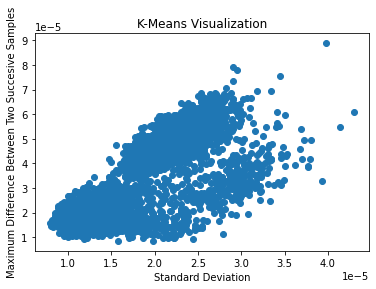

In [13]:
plt.scatter(features1['std'], features1['diff'])
plt.xlabel('Standard Deviation')
plt.ylabel('Maximum Difference Between Two Succesive Samples')
plt.title('K-Means Visualization')
plt.show()

By visual inspection of the plotted features, we can identify 3 clusters for electrode 1.

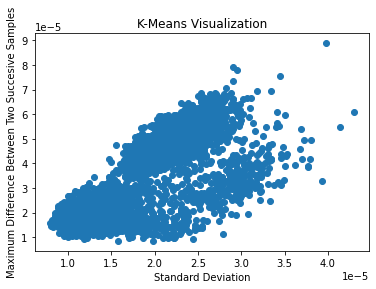

In [14]:
plt.scatter(features1['std'], features1['diff'])
plt.xlabel('Standard Deviation')
plt.ylabel('Maximum Difference Between Two Succesive Samples')
plt.title('K-Means Visualization')
plt.show()

By visual inspection of the plotted features, we can identify 3 clusters for electrode 2.

### Identifying the clusters programatically

In [15]:
def addCluster(features):
    X = features[['diff', 'std']]
    kmeans = KMeans(n_clusters=3)
    features['cluster'] = kmeans.fit_predict(X)
    #the below will make sure the neuron cluster is always consitent ie neuron 0 wont be top in first but bottom in second
    clusterMean = features.groupby('cluster').mean().sort_values('diff')['diff'].index
    mapCluster = {cluster: i for i, cluster in enumerate(clusterMean)}
    features['cluster'] = features['cluster'].map(mapCluster)
    
    return features

Here we use a machine learning algorithim, K-means-clusters to divide the spikes into 3 clusters. This adds another feature to the features dataframe which is the cluster category. We now know which neuron the spikes belong too.

In [17]:
features1 = addCluster(features1)
features2 = addCluster(features2)
features1

,std,diff,peakIndex,timeStamp,cluster
0,0.000015,0.000028,745,0.030515,0
1,0.000011,0.000019,1226,0.050217,0
3,0.000014,0.000016,2025,0.082944,0
4,0.000015,0.000018,3236,0.132547,0
5,0.000014,0.000030,3675,0.150528,0
...,...,...,...,...,...
4514,0.000010,0.000027,4410006,180.634308,0
4515,0.000014,0.000020,4410057,180.636397,0
4518,0.000011,0.000023,4416143,180.885680,0
4520,0.000014,0.000017,4416735,180.909929,0


### Plotting the features after clustering

In [35]:
def plotFeatures(features):
    plt.scatter(features['std'], features['diff'], c=features['cluster'], cmap='plasma')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Maximum Difference Between Two Succesive Samples')
    plt.title('K-Means Visualization')
    plt.show()
    return features

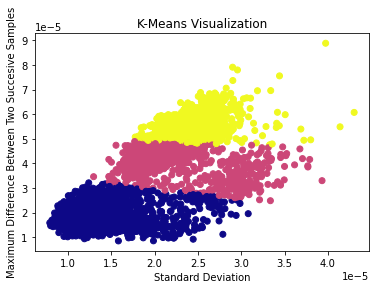

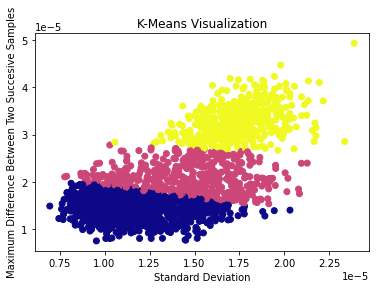

In [36]:
features1 = plotFeatures(features1)
features2 = plotFeatures(features2)

We can now tell which spike belongs to which neuron visually.

### Plotting the electrode signals, this time identifying the different neurons in which each spike belongs to

In [37]:
def plotSignal(Osignal,featuers):
    peaks = featuers['peakIndex'].values
    clusters = featuers['cluster'].values
    unique_clusters = np.unique(clusters)

    valid_indices = (peaks <= 20000) & (np.arange(len(clusters)) <= 20000)

    valid_peaks = peaks[valid_indices]
    valid_clusters = clusters[valid_indices]

    signal = Osignal.iloc[:20000].to_numpy()
    plt.plot(signal, label='Signal')

    cluster_colors = ['red', 'green', 'yellow'] 
    for i, cluster in enumerate(unique_clusters):
      cluster_peaks = valid_peaks[valid_clusters == cluster]
      plt.scatter(cluster_peaks, signal[cluster_peaks], label=f'Cluster {cluster}', color=cluster_colors[i], marker='o')

    plt.title(f'Signal with Clustered Peaks (First {20000} samples)')
    plt.xlabel('Peak')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.show()


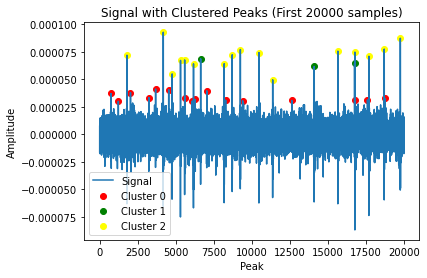

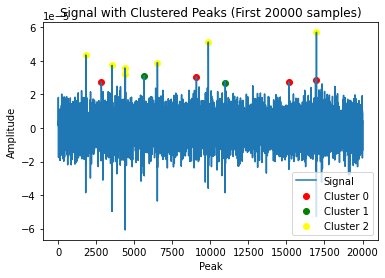

In [38]:
plotSignal(first, features1)
plotSignal(second, features2)

### Lastly we plot the average neuron spike for each neuron and for each electrode

This is done by taking half the window size to the right of the peak index and half a window size to the left of the peak index, and taking the average values of each cluster in that window, the values are then plotted on the graphs below

In [54]:
def plotAverageNeurons(feauture, data):
    clusters = np.unique(feauture["cluster"])

    color = ["#"+''.join([random.choice('0369CEF') for j in range(6)])
                for i in range(len(clusters))]

    avg_spikes = []
    for cluster in clusters:
        allSpikes = []
        for ind in feauture[feauture["cluster"] == cluster]["peakIndex"]:
            start = ind - 24
            end = ind + 24
            allSpikes.append([data[start:end]])
        avg_spikes.append(np.average(allSpikes, axis = 0)[0])

    indices = np.arange(len(avg_spikes[0]))
    for cluster in clusters:
        plt.plot(indices, avg_spikes[cluster], color=color[cluster], label="neuron "+str(cluster+1))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Single Spike Waveform')
    plt.legend()

    plt.grid(True)
    plt.show()
    return avg_spikes

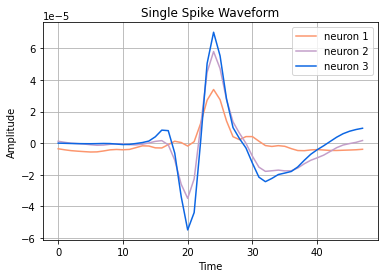

[array([-3.47735098e-06, -4.13508600e-06, -4.67279492e-06, -5.00845379e-06,
        -5.29108143e-06, -5.53274480e-06, -5.45623705e-06, -4.88353815e-06,
        -4.17387236e-06, -3.92544683e-06, -4.11140354e-06, -3.90389032e-06,
        -2.79349271e-06, -1.62699070e-06, -1.74676137e-06, -2.90008427e-06,
        -2.98215940e-06, -8.61120784e-07,  1.27703897e-06,  4.55721949e-07,
        -1.76610262e-06,  1.00451153e-06,  1.25275898e-05,  2.72244534e-05,
         3.40003752e-05,  2.75814304e-05,  1.40786437e-05,  4.15451375e-06,
         2.25545230e-06,  4.21544574e-06,  4.20981210e-06,  1.29838978e-06,
        -1.45250588e-06, -2.01266260e-06, -1.51810910e-06, -1.93214529e-06,
        -3.40920541e-06, -4.60811289e-06, -4.70611179e-06, -4.21754183e-06,
        -4.01700097e-06, -4.27372010e-06, -4.55653463e-06, -4.56792417e-06,
        -4.41629331e-06, -4.27941985e-06, -4.11629555e-06, -3.81509957e-06]),
 array([ 1.25833536e-06,  5.95074348e-07,  3.01448431e-08, -2.39117396e-07,
        -4

In [58]:
avg_spike_1 = plotAverageNeurons(features1, first)
avg_spike_1

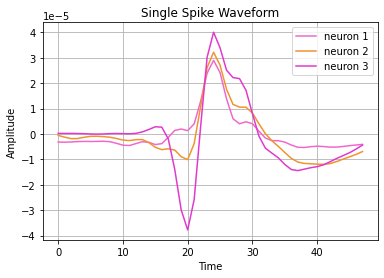

[array([-3.18633647e-06, -3.25098858e-06, -3.15661548e-06, -3.00929556e-06,
        -2.94473457e-06, -2.96364080e-06, -2.94143062e-06, -2.87936675e-06,
        -3.05275202e-06, -3.68309924e-06, -4.43361000e-06, -4.55188567e-06,
        -3.80733039e-06, -3.05936863e-06, -3.32422898e-06, -4.17722670e-06,
        -3.80972130e-06, -1.35767641e-06,  1.37765695e-06,  1.94791016e-06,
         1.28503627e-06,  3.98544839e-06,  1.28593535e-05,  2.39089146e-05,
         2.89789388e-05,  2.41088516e-05,  1.37920582e-05,  5.97871087e-06,
         4.00624544e-06,  4.78550768e-06,  4.01163560e-06,  1.08865930e-06,
        -1.62835384e-06, -2.61207461e-06, -2.67599799e-06, -3.21814215e-06,
        -4.36345983e-06, -5.23993267e-06, -5.34098366e-06, -5.01256995e-06,
        -4.83033031e-06, -4.96522559e-06, -5.17713854e-06, -5.17922479e-06,
        -4.92881812e-06, -4.60991305e-06, -4.36189406e-06, -4.11576929e-06]),
 array([-5.86870471e-07, -1.26465723e-06, -1.84249387e-06, -1.80954119e-06,
        -1

In [59]:
avg_spike_2 = plotAverageNeurons(features2, second)
avg_spike_2

In [46]:
def getNeuronFeatures(features, cluster):
    return features[features["cluster"] == cluster].drop("cluster", axis=1)

In [47]:
neuron1_1 = getNeuronFeatures(features1, 0)
neuron1_1

,std,diff,peakIndex,timeStamp
0,0.000015,0.000028,745,0.030515
1,0.000011,0.000019,1226,0.050217
3,0.000014,0.000016,2025,0.082944
4,0.000015,0.000018,3236,0.132547
5,0.000014,0.000030,3675,0.150528
...,...,...,...,...
4514,0.000010,0.000027,4410006,180.634308
4515,0.000014,0.000020,4410057,180.636397
4518,0.000011,0.000023,4416143,180.885680
4520,0.000014,0.000017,4416735,180.909929


In [48]:
neuron2_1 = getNeuronFeatures(features1, 1)
neuron2_1

,std,diff,peakIndex,timeStamp
15,0.000021,0.000045,6636,0.271811
25,0.000030,0.000042,14094,0.577292
27,0.000032,0.000029,16748,0.686000
51,0.000018,0.000041,43311,1.774023
72,0.000026,0.000029,68389,2.801221
...,...,...,...,...
4509,0.000021,0.000043,4408450,180.570574
4510,0.000017,0.000034,4408633,180.578070
4512,0.000019,0.000034,4409410,180.609896
4513,0.000022,0.000048,4409875,180.628942


In [49]:
neuron3_1 = getNeuronFeatures(features1, 2)
neuron3_1

,std,diff,peakIndex,timeStamp
2,0.000025,0.000054,1793,0.073441
6,0.000029,0.000066,4180,0.171213
8,0.000020,0.000051,4761,0.195011
9,0.000023,0.000057,5312,0.217580
10,0.000023,0.000053,5585,0.228762
...,...,...,...,...
4499,0.000021,0.000054,4405193,180.437167
4511,0.000021,0.000058,4409385,180.608872
4516,0.000022,0.000050,4412558,180.738838
4517,0.000024,0.000052,4414290,180.809781


In [50]:
neuron1_2 = getNeuronFeatures(features2, 0)
neuron1_2

,std,diff,peakIndex,timeStamp
1,0.000012,0.000011,2837,0.116204
7,0.000010,0.000015,9083,0.372041
10,0.000011,0.000018,15163,0.621078
11,0.000013,0.000015,16913,0.692758
14,0.000009,0.000016,21970,0.899894
...,...,...,...,...
2038,0.000009,0.000018,4403622,180.372819
2040,0.000015,0.000012,4404890,180.424756
2041,0.000010,0.000012,4409131,180.598468
2042,0.000010,0.000012,4413009,180.757311


In [51]:
neuron2_2 = getNeuronFeatures(features2, 1)
neuron2_2

,std,diff,peakIndex,timeStamp
5,0.000010,0.000028,5657,0.231711
9,0.000015,0.000025,10978,0.449660
15,0.000015,0.000024,24081,0.986360
20,0.000012,0.000019,30971,1.268575
38,0.000016,0.000023,64075,2.624519
...,...,...,...,...
2021,0.000014,0.000019,4366930,178.869911
2023,0.000019,0.000020,4370775,179.027402
2025,0.000010,0.000021,4373748,179.149177
2037,0.000013,0.000018,4403479,180.366962


In [52]:
neuron3_2 = getNeuronFeatures(features2, 2)
neuron3_2

,std,diff,peakIndex,timeStamp
0,0.000018,0.000030,1814,0.074302
2,0.000019,0.000034,3542,0.145081
3,0.000022,0.000030,4385,0.179610
4,0.000021,0.000034,4414,0.180798
6,0.000017,0.000033,6520,0.267060
...,...,...,...,...
1999,0.000014,0.000032,4304720,176.321783
2014,0.000015,0.000034,4345238,177.981404
2033,0.000016,0.000031,4397511,180.122512
2035,0.000017,0.000032,4400415,180.241460
